In [1]:
import keras

Using TensorFlow backend.


In [2]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

In [3]:
train_data.shape
# 훈련데이터 크기는 404개

(404, 13)

In [4]:
test_data.shape
# 테스트데이터 크기는 102개
test_data[1]
# 이렇게 각 13개의 특성이 담겨있다

array([1.2329e-01, 0.0000e+00, 1.0010e+01, 0.0000e+00, 5.4700e-01,
       5.9130e+00, 9.2900e+01, 2.3534e+00, 6.0000e+00, 4.3200e+02,
       1.7800e+01, 3.9495e+02, 1.6210e+01])

In [5]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [6]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

# 모델의 아웃풋 크기는 1이다.
# 인풋의 크기는 64이며 보스턴 집값문제에서 모델을 여러번 생성하기에 함수로 만든다.

In [7]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('처리중인 폴드 #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)
    
# partial_train로 분할된 train_data를 하나로 합친다.
# Mean Squared Error 와 Mean Absolute Error 깂을 val_data, val_targets로 구한다.
# KFold 교차검증을 위한 데이터 분리


W0729 15:49:41.522032 140668711073600 deprecation_wrapper.py:119] From /home/aaronroh/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0729 15:49:41.535014 140668711073600 deprecation_wrapper.py:119] From /home/aaronroh/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0729 15:49:41.536772 140668711073600 deprecation_wrapper.py:119] From /home/aaronroh/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0729 15:49:41.572342 140668711073600 deprecation_wrapper.py:119] From /home/aaronroh/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [8]:
from keras import backend as K

K.clear_session()
# 여러 모델을 생성하였으므로 clear_session을 통해서 이전 모델로부터 남은 노드들을 제거한다.

In [ ]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('처리중인 폴드 #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    # 위의 코드와 동일함

    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

In [10]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

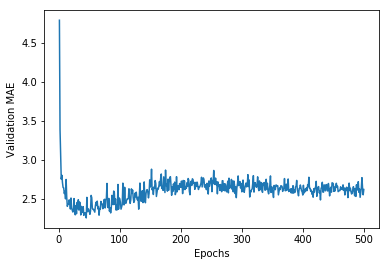

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

# Mean Absolute error 검증에 대한 그래프다.

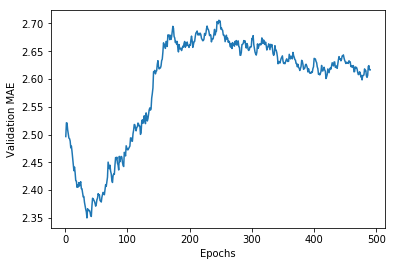

In [12]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

#위의 그래프에 나온 값에서 앞의 10개 값은 다른 데이터와 차이가 급격하게 많이 나므로 제외하고
# 보다 원만하고자 smootH_curve 이용.

In [13]:
model = build_model()

model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
# 모델 훈련후 평가

102/102 [==============================] - 0s 486us/step


In [14]:
print(test_mae_score, test_mse_score)

2.681471497404809 17.91167225557215
